# LING 539: SP 2024 class competition

Author: Maksim Kulik

## Setup

In [13]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

nltk.download('punkt')
pd.set_option('display.max_columns', None)
sns.set(font_scale = 1.25)
sns.set_style("white")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxcu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Exploring the data

The training dataset contains almost 70,000 texts. Some of these texts are movie reviews, but not all. Using this data, we will build a model that will classify any text as one of the three possible things: not a movie review, a positive movie review or a negative movie review.

The dataset contains only 3 columns:

- ID:  Unique ID.
- TEXT:  The text of the document.
- LABEL:  The label for this document, with 0 meaning it's not a movie review, 1 meaning it's a positive movie review and 2 meaning it's a negative movie review.

### Loading the data

In [14]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f'First 5 rows:\n{train.head()}', f'Data types:\n{train.dtypes}', 
      f'The dataset contains {train.shape[0]} rows and {train.shape[1]} columns.', sep='\n\n')

First 5 rows:
                     ID                                               TEXT  \
0   7850790573542594519  If you love good films don't ever buy this pei...   
1   9392069522632994700  The 33 percent of the nations nitwits that sti...   
2   5083704536542443514  I saw Anatomy years ago -- dubbed at a friends...   
3  12418349755186772171  Dark Remains is a home run plain and simple. T...   
4  12144957944004619479  Feh. This movie started out in an interesting ...   

   LABEL  
0      2  
1      2  
2      1  
3      1  
4      2  

Data types:
ID       uint64
TEXT     object
LABEL     int64
dtype: object

The dataset contains 70317 rows and 3 columns.


### Distribution of labels

As we see on the plot, almost half of the texts in the dataset are not movie reviews. Of the reaining half, the distribution between positive and negative reviews is almost 50/50. This is a fairly even distribution overall, which means we will have enough samples for each of the three classes we are trying to predict.

([<matplotlib.axis.XTick at 0x118e2fa9e90>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

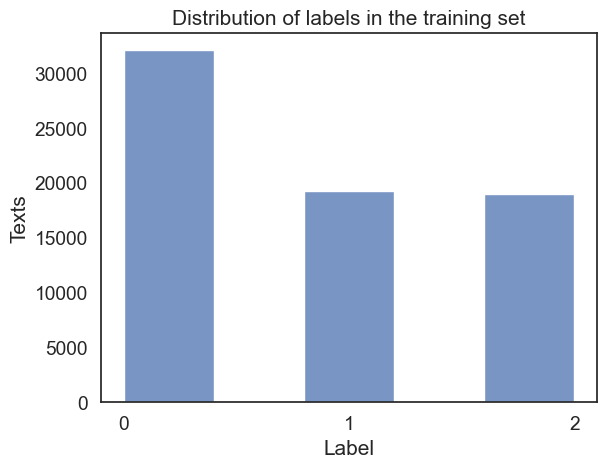

In [15]:
train_copy = train.copy()

hist = sns.histplot(data=train_copy, x="LABEL", binwidth=.4)
labels = hist.set(xlabel="Label", ylabel="Texts", title='Distribution of labels in the training set')
plt.xticks(np.array([0, 1, 2]))

## 2. Cleaning & encoding

### Cleaning

First, we check for any missing values. There are just 6, and since it's the texts that are missing, there seems to be no reasonable way to impute or substitute them. Luckily, for a dataset this size we lose nothing by just dropping them.

In [16]:
print(train.isnull().sum(), '\n')
print(test.isnull().sum())

train_cleaned = train.dropna()
test = test.fillna('random string')

ID       0
TEXT     6
LABEL    0
dtype: int64 

ID      0
TEXT    1
dtype: int64


The dataset contains a number of texts that are not in English. There are also some texts that are not in any known language, but rather a result of encoding error or just a random sequence of characters. We will filter these out using the .isascii method.

In [17]:
train_cleaned = train_cleaned[train_cleaned.TEXT.apply(str.isascii)]

### Tokenization & stemming

We define a function that combines the NLTK's standard tokenizer with the PorterStemmer, and then we apply this function to the column in our dataframe that contains the texts. We go with stemming over lemmatization because stemming is a simpler approach that does not need knowledge of dictionary forms to function and can tackle any word.

In [18]:
def tokenize_stem(text):
    ps = PorterStemmer()
    return [ps.stem(w) for w in nltk.word_tokenize(text)]

train_cleaned['stemmed_tokens'] = train_cleaned['TEXT'].apply(tokenize_stem)
test['stemmed_tokens'] = test['TEXT'].apply(tokenize_stem)



### Encoding

We use CountVectorizer to derive the features. We use both unigrams and bigrams and set max_df at 0.7 to remove stop words. Count vectorizing is a simple approach that uses token counts to create a representation of a text. It also has a very low computatinal intensity, requiring just about 10 seconds to encode a dataset with more than 60,000 texts.

In [19]:
vectorizer = CountVectorizer(max_df=.7, ngram_range=(1, 2), token_pattern=None, analyzer=lambda x: x)

train_features = vectorizer.fit_transform(train_cleaned['stemmed_tokens'])
test_features = vectorizer.transform(test['stemmed_tokens'])

c:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:541: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


## 3. Training & evaluation

### Training

We use a single logistic regression to train it to predict one of the three possible classes. An alternative approach would be to split the task into two binary classification problems, first predicting whether a text is a movie review, and then conducting sentiment analysis only on the texts that are classified as movie reviews. This would increase the complexity of the code, as well as the computational load, so we are sticking with our original minimalist approach and only using a single classifier.

In [20]:
clf = LogisticRegression(solver="liblinear", multi_class="ovr")

X_train, X_test, y_train, y_test = train_test_split(train_features, train_cleaned['LABEL'], test_size=.2, random_state=42)

clf.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(multi_class='ovr', solver='liblinear')

### Evaluation

In [21]:
pred = clf.predict(X_test)

f1_score(y_test, pred, average='macro')

0.9012529278259581

### Generating submission

Now that we have achieved optimal performance, we can train the model on all available data and generate a file with the predictions to submit it for competition.

In [22]:
clf.fit(train_features, train_cleaned['LABEL'])

test['LABEL'] = clf.predict(test_features)

Finally, we can export our submission file predictions.csv to the \data folder.

In [23]:
test[['ID', 'LABEL']].to_csv('data/predictions.csv', index=False)